# Introduction

Here we check the sPHENIX field map and separate the in-steel field from the outside

In [1]:
# imports to write dynamic markdown contents
import os
from IPython.display import display, Markdown, Latex
from IPython.display import HTML

## Initialization

In [2]:
# turn off/on code for the result HTML page

display(Markdown('*For the result HTML page:* '))
    
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

*For the result HTML page:* 

In [3]:
import ROOT

OFFLINE_MAIN = os.getenv("OFFLINE_MAIN")
if OFFLINE_MAIN is not None:
    display(Markdown(f"via sPHENIX software distribution at `{OFFLINE_MAIN}`"))

Welcome to JupyROOT 6.26/06


via sPHENIX software distribution at `/cvmfs/sphenix.sdcc.bnl.gov/gcc-12.1.0/release/release_ana/ana.410`

In [4]:
import uproot
from tqdm.notebook import tqdm_notebook
import pandas as pd

tqdm_notebook.pandas()

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('seaborn-v0_8-white')

import numpy as np

from os.path import exists


# Before 2022: 2D Field map export

In [5]:
MapFile2D = '/cvmfs/eic.opensciencegrid.org/ecce/gcc-8.3/release/release_prop/prop.7/share/calibrations//Field/Map/sPHENIX.2d.root'

# 2D field map scaling on its working point
# https://github.com/ECCE-EIC/macros/blob/prop.7.0/detectors/EICDetector/Fun4All_G4_EICDetector.C#L460 
magfield_2D_rescale = -1.4 / 1.5;

In [6]:
display(Markdown(f'2D field map from `{MapFile2D}`'))

2D field map from `/cvmfs/eic.opensciencegrid.org/ecce/gcc-8.3/release/release_prop/prop.7/share/calibrations//Field/Map/sPHENIX.2d.root`

In [7]:
file = uproot.open(MapFile2D)

In [8]:
file.keys()

['fieldmap;1', 'h1;1']

In [9]:
file['fieldmap'].keys()

['r', 'z', 'br', 'bz']

In [10]:
df_fieldmap = file['fieldmap'].arrays(library="pd")

df_fieldmap['br'] = df_fieldmap['br'].progress_apply(lambda x: x * magfield_2D_rescale)
df_fieldmap['bz'] = df_fieldmap['bz'].progress_apply(lambda x: x * magfield_2D_rescale)

  0%|          | 0/60551 [00:00<?, ?it/s]

  0%|          | 0/60551 [00:00<?, ?it/s]

In [11]:
df_fieldmap

r      z        br        bz
0      300.0  400.0  0.004610 -0.002614
1      298.0  400.0  0.004837 -0.002521
2      296.0  400.0  0.005066 -0.002391
3      294.0  400.0  0.005322 -0.002253
4      292.0  400.0  0.005585 -0.002108
...      ...    ...       ...       ...
60546    8.0 -400.0 -0.002663  0.007943
60547    6.0 -400.0 -0.002007  0.008361
60548    4.0 -400.0 -0.001348  0.008561
60549    2.0 -400.0 -0.000696  0.008769
60550    0.0 -400.0 -0.000000  0.008848

[60551 rows x 4 columns]

In [12]:

X=df_fieldmap['z'].values
Y=df_fieldmap['r'].values
Z=df_fieldmap.progress_apply(lambda x: np.sqrt(x['br']*x['br'] + x['bz']*x['bz']), axis=1).values

limits =  np.arange(0,2.5,.1);


  0%|          | 0/60551 [00:00<?, ?it/s]

## Check field map plot

And Hcal is treated as a homogenious material in 2D field map, which has to be modified via our HCal field after-burner to produce 3D field that match Hcal sample structure. 

/tmp/ipykernel_38734/1728907782.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


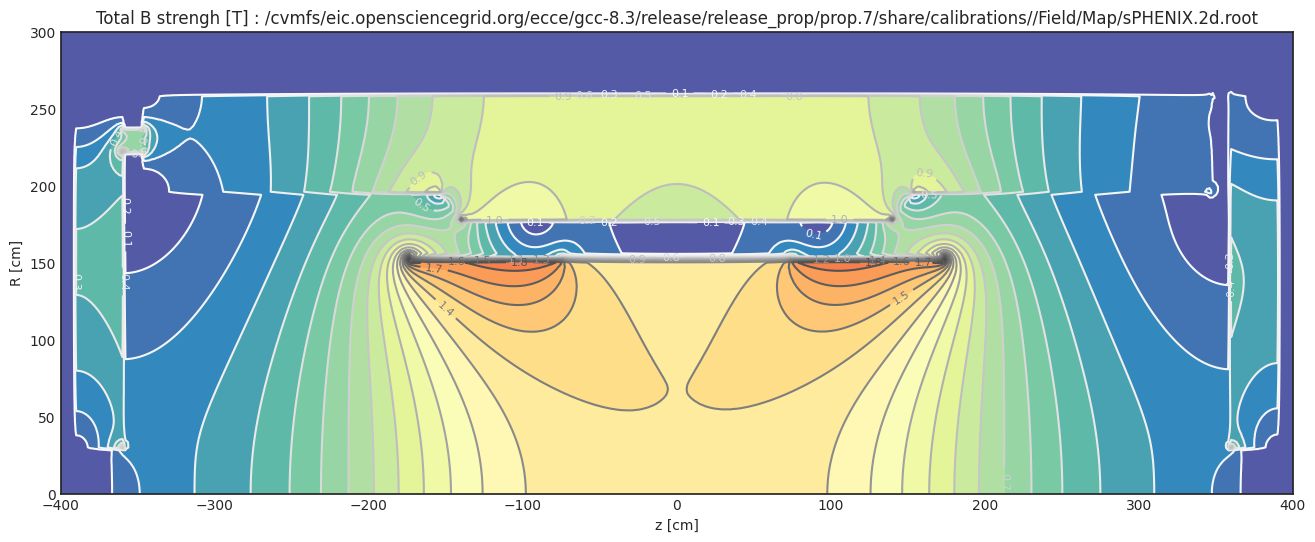

In [13]:
fig, ax = plt.subplots(figsize=(16,6))
ax.set_aspect('equal')
ax.tricontourf(X,Y,Z,limits, cmap='Spectral_r') 
contours = ax.tricontour(X,Y,Z, limits)
ax.clabel(contours, inline=True, fontsize=8)

ax.set_xlabel('z [cm]')
ax.set_ylabel('R [cm]')
ax.set_title("Total B strengh [T] : " + MapFile2D)

fig.show()

In [14]:
df_fieldmap.to_csv('sPHENIX.2d.csv');

# Since 2022: 3D field map in simulation

In [15]:
# MapFile3D = '/phenix/u/jinhuang/links/sPHENIX_work/FieldMap/justoutsidedoor.table'
MapFile3D = '/phenix/u/jinhuang/links/sPHENIX_work/FieldMap/sphenix_2019_f_shift=2p85cm_warp_z355cm.table'

In [16]:
display(Markdown(f'3D field map from `{MapFile3D}`'))

3D field map from `/phenix/u/jinhuang/links/sPHENIX_work/FieldMap/sphenix_2019_f_shift=2p85cm_warp_z355cm.table`

In [17]:
df_fieldmap = pd.read_csv(MapFile3D, header=None,  sep='\s+', dtype=np.float64,
                          names = ['x',	'y',	'z',	'bx[Gauss]',	'by[Gauss]',	'bz[Gauss]',	'hz[OERSTED]'])

In [18]:
df_fieldmap['bx']=df_fieldmap.progress_apply(lambda x: x['bx[Gauss]']*1e-4, axis=1)
df_fieldmap['by']=df_fieldmap.progress_apply(lambda x: x['by[Gauss]']*1e-4, axis=1)
df_fieldmap['bz']=df_fieldmap.progress_apply(lambda x: x['bz[Gauss]']*1e-4, axis=1)

  0%|          | 0/26144996 [00:00<?, ?it/s]

  0%|          | 0/26144996 [00:00<?, ?it/s]

  0%|          | 0/26144996 [00:00<?, ?it/s]

In [19]:
df_fieldmap

x      y      z  bx[Gauss]  by[Gauss]  bz[Gauss]  hz[OERSTED]  \
0        -270.0 -270.0 -355.0  18.074328  17.969896 -21.351164   -21.351164   
1        -270.0 -270.0 -353.0  17.860810  17.755849 -21.787540   -21.787540   
2        -270.0 -270.0 -351.0  17.644602  17.539112 -22.244480   -22.244480   
3        -270.0 -270.0 -349.0  17.388773  17.282755 -22.983381   -22.983381   
4        -270.0 -270.0 -347.0  17.114001  17.007447 -23.453435   -23.453435   
...         ...    ...    ...        ...        ...        ...          ...   
26144991  270.0  270.0  347.0  18.059289  17.518345 -25.280238   -25.280238   
26144992  270.0  270.0  349.0  18.357577  17.822652 -24.778117   -24.778117   
26144993  270.0  270.0  351.0  18.635552  18.106583 -23.988424   -23.988424   
26144994  270.0  270.0  353.0  18.871031  18.347897 -23.499815   -23.499815   
26144995  270.0  270.0  355.0  19.103626  18.586319 -23.033165   -23.033165   

                bx        by        bz  
0         0.001807  0.001797 -0.002135  
1         0.001786  0.001776 -0.002179  
2         0.001764  0.001754 -0.002224  
3         0.001739  0.001728 -0.002298  
4         0.001711  0.001701 -0.002345  
...            ...       ...       ...  
26144991  0.001806  0.001752 -0.002528  
26144992  0.001836  0.001782 -0.002478  
26144993  0.001864  0.001811 -0.002399  
26144994  0.001887  0.001835 -0.002350  
26144995  0.001910  0.001859 -0.002303  

[26144996 rows x 10 columns]

/tmp/ipykernel_38734/2164255805.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_fieldmap.hist(ax=axis, bins=100)


array([[<AxesSubplot: title={'center': 'x'}>,
        <AxesSubplot: title={'center': 'y'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 'bx[Gauss]'}>,
        <AxesSubplot: title={'center': 'by[Gauss]'}>,
        <AxesSubplot: title={'center': 'bz[Gauss]'}>],
       [<AxesSubplot: title={'center': 'hz[OERSTED]'}>,
        <AxesSubplot: title={'center': 'bx'}>,
        <AxesSubplot: title={'center': 'by'}>],
       [<AxesSubplot: title={'center': 'bz'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

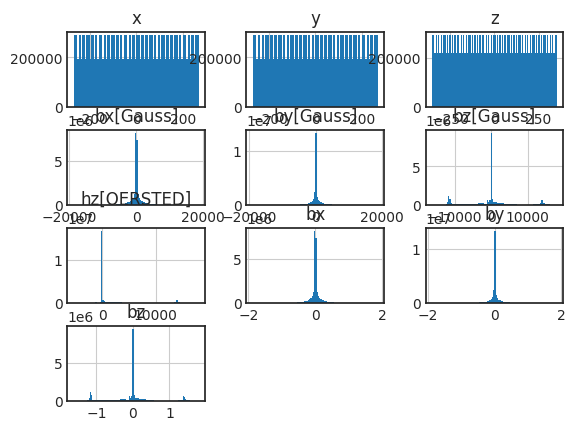

In [20]:
#define number of subplots
fig, axis = plt.subplots(1, 1)

#create histogram for each column in DataFrame
df_fieldmap.hist(ax=axis, bins=100)

In [21]:
df_fieldmap.agg(['min', 'max'])

x      y      z     bx[Gauss]     by[Gauss]     bz[Gauss]  \
min -270.0 -270.0 -355.0 -18704.115619 -18903.255335 -16263.587540   
max  270.0  270.0  355.0  18705.348339  18701.018468  18053.113232   

      hz[OERSTED]        bx        by        bz  
min  -5303.963784 -1.870412 -1.890326 -1.626359  
max  18053.113232  1.870535  1.870102  1.805311

In [22]:
df_fieldmap[(df_fieldmap['x'] == 0) & (df_fieldmap['y'] == 0) & (df_fieldmap['z'] >= -1) & (df_fieldmap['z'] <=1) ]

x    y    z  bx[Gauss]  by[Gauss]     bz[Gauss]   hz[OERSTED]  \
13072497  0.0  0.0 -1.0   0.345347  -0.081175  13847.726835  13847.726835   
13072498  0.0  0.0  1.0   0.348318  -0.126922  13848.448823  13848.448823   

                bx        by        bz  
13072497  0.000035 -0.000008  1.384773  
13072498  0.000035 -0.000013  1.384845

## Check field map plot

### `x=0` plane

Plotted both in $|B|$ and $B_z$

In [23]:
df_fieldmap_yz = df_fieldmap[df_fieldmap['x'] == 0]

In [24]:
df_fieldmap_yz

x      y      z    bx[Gauss]    by[Gauss]   bz[Gauss]  \
13024260  0.0 -270.0 -355.0    -0.025305    76.896451  166.453952   
13024261  0.0 -270.0 -353.0    -0.468131    71.718396  169.301286   
13024262  0.0 -270.0 -351.0 -1121.391709  1082.513359  197.807216   
13024263  0.0 -270.0 -349.0 -1195.763076   999.820748  137.998678   
13024264  0.0 -270.0 -347.0 -1243.970317   965.491932  -38.655874   
...       ...    ...    ...          ...          ...         ...   
13120731  0.0  270.0  347.0   175.216792  1197.040629  -40.989814   
13120732  0.0  270.0  349.0   174.840746  1232.172062  152.391846   
13120733  0.0  270.0  351.0   172.866410  1274.048707  215.762956   
13120734  0.0  270.0  353.0     0.103349    77.049026  177.549078   
13120735  0.0  270.0  355.0     0.366986    82.212085  174.878569   

          hz[OERSTED]        bx        by        bz  
13024260   166.453952 -0.000003  0.007690  0.016645  
13024261   169.301286 -0.000047  0.007172  0.016930  
13024262     0.011028 -0.112139  0.108251  0.019781  
13024263     0.006509 -0.119576  0.099982  0.013800  
13024264    -0.002210 -0.124397  0.096549 -0.003866  
...               ...       ...       ...       ...  
13120731    -0.001078  0.017522  0.119704 -0.004099  
13120732     0.001325  0.017484  0.123217  0.015239  
13120733     0.002434  0.017287  0.127405  0.021576  
13120734   177.549078  0.000010  0.007705  0.017755  
13120735   174.878569  0.000037  0.008221  0.017488  

[96476 rows x 10 columns]

In [25]:

X=df_fieldmap_yz['z'].values
Y=df_fieldmap_yz['y'].values
Z=df_fieldmap_yz.progress_apply(lambda x: np.sqrt(x['bx']*x['bx'] + x['by']*x['by'] + x['bz']*x['bz']), axis=1).values

limits =  np.arange(0,2.5,.1);


  0%|          | 0/96476 [00:00<?, ?it/s]

/tmp/ipykernel_38734/2608094341.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


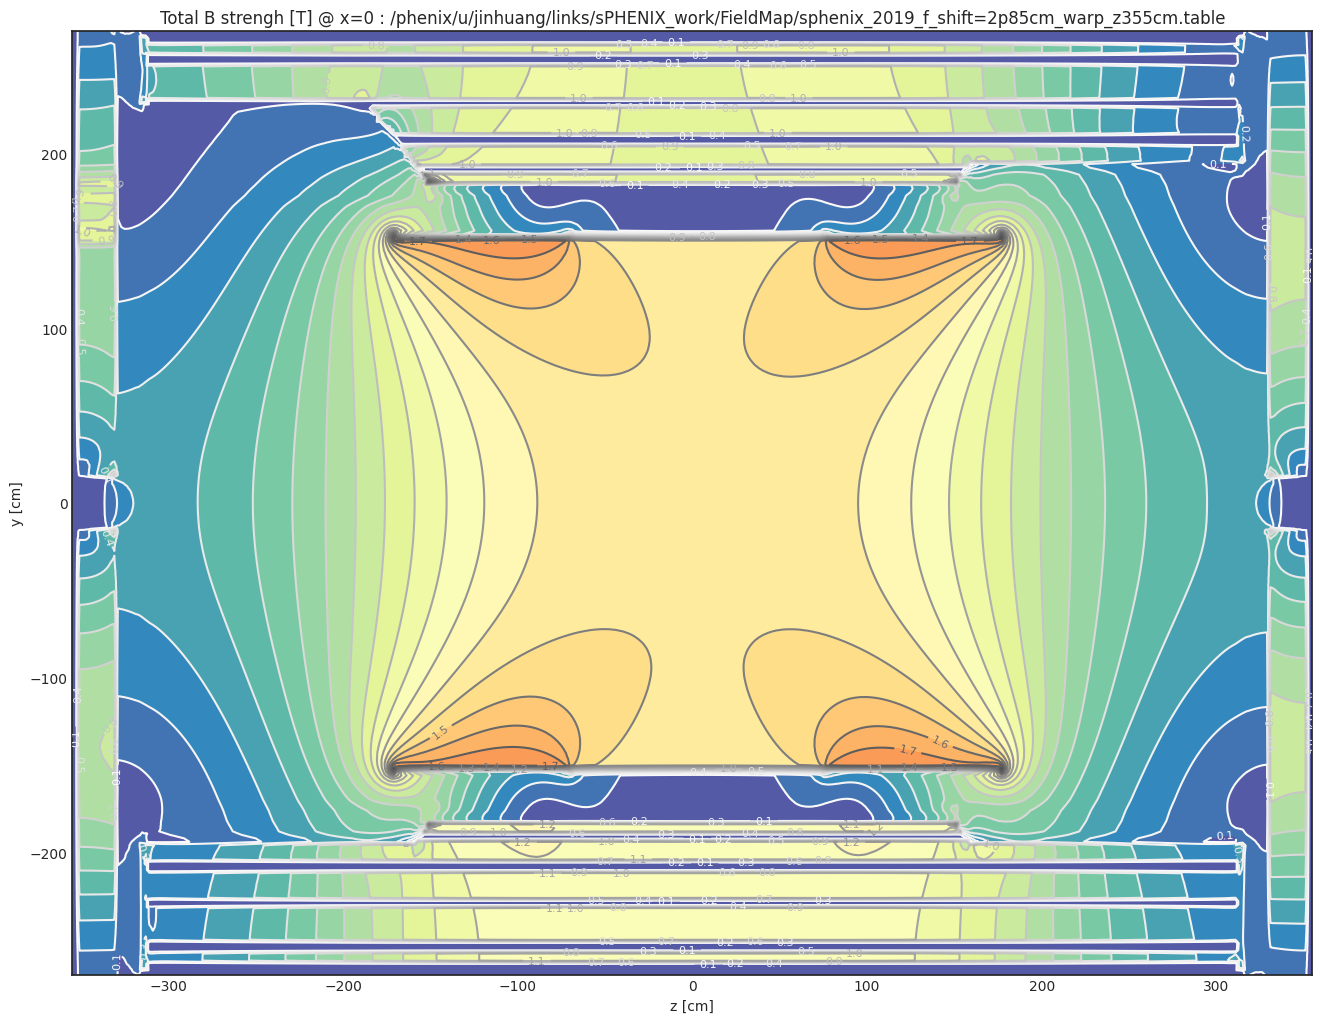

In [26]:
fig, ax = plt.subplots(figsize=(16,16))
ax.set_aspect('equal')
ax.tricontourf(X,Y,Z,limits, cmap='Spectral_r') 
contours = ax.tricontour(X,Y,Z, limits)
ax.clabel(contours, inline=True, fontsize=8)

ax.set_xlabel('z [cm]')
ax.set_ylabel('y [cm]')
ax.set_title("Total B strengh [T] @ x=0 : " + MapFile3D)

fig.show()

/tmp/ipykernel_38734/2989865075.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


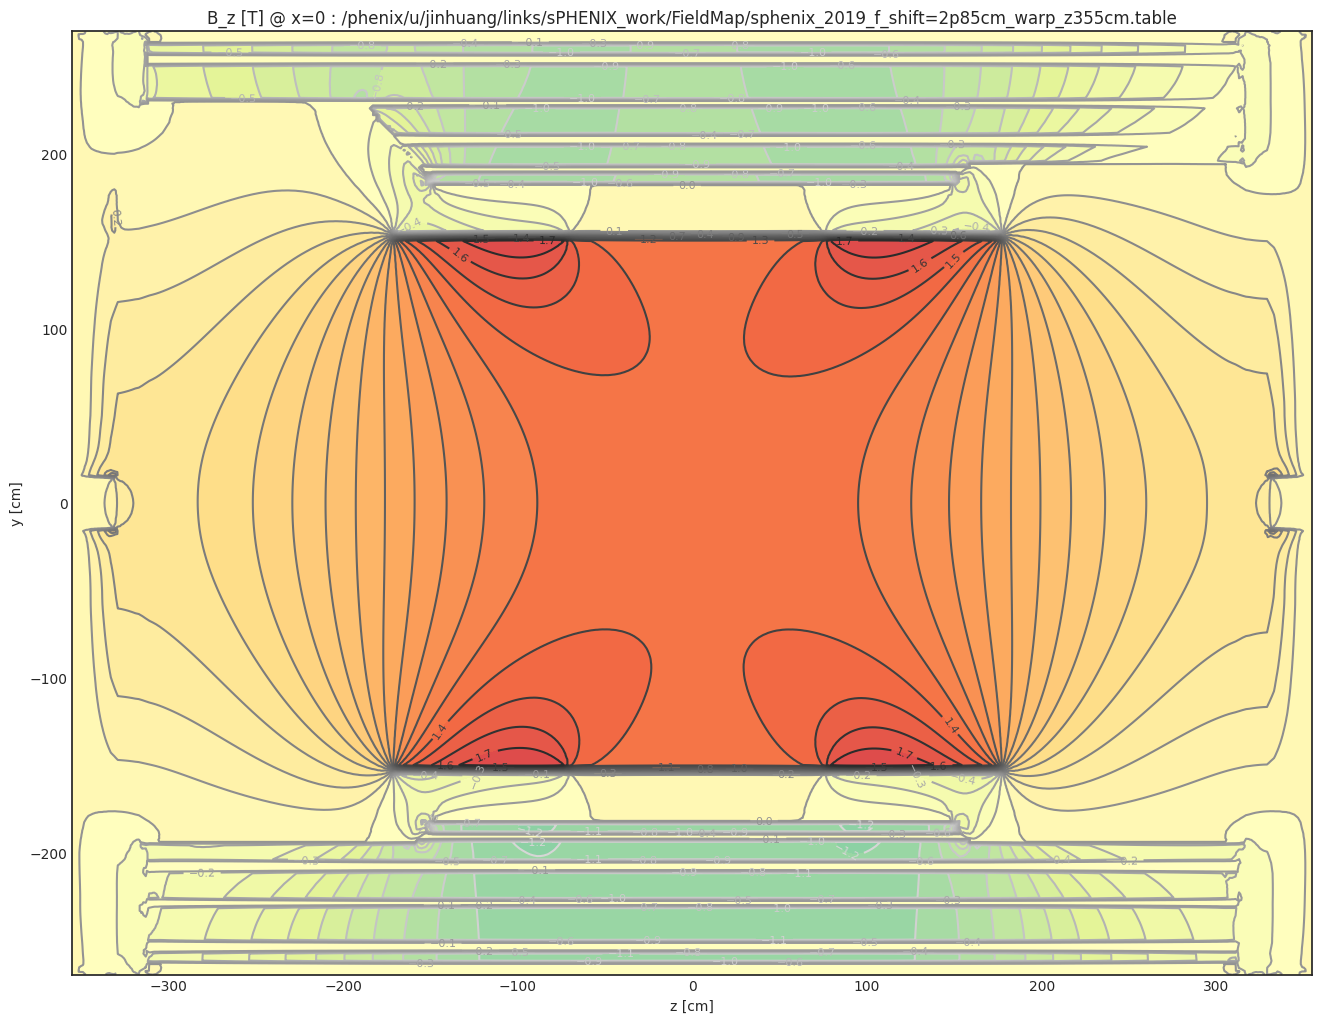

In [27]:
limits =  np.arange(-2.5,2.5,.1);

fig, ax = plt.subplots(figsize=(16,16))
ax.set_aspect('equal')
ax.tricontourf(X,Y,df_fieldmap_yz['bz'].values,limits, cmap='Spectral_r') 
contours = ax.tricontour(X,Y,df_fieldmap_yz['bz'].values, limits)
ax.clabel(contours, inline=True, fontsize=8)

ax.set_xlabel('z [cm]')
ax.set_ylabel('y [cm]')
ax.set_title("B_z [T] @ x=0 : " + MapFile3D)

fig.show()

# In steel vs out of steel

Next let's see whether there are sufficient space point around HCal to tell field from in steel vs outside. The stat for field point in the gap is low given the small gap, and the field points in the HCal randomly points to in the steel and outside the steel. Given G4 field map use a 3D interpolation that assuming smooth field distribution, this leads to improper field map in HCal.

In [28]:
df_fieldmap_xy = df_fieldmap[(df_fieldmap['z'] >= 0) & (df_fieldmap['z'] <=1)]

df_fieldmap_xy.insert(loc=1, column='B_tot', value=df_fieldmap_xy.progress_apply(lambda x: np.sqrt(x['bx']*x['bx'] + x['by']*x['by'] + x['bz']*x['bz']), axis=1))
df_fieldmap_xy.insert(loc=1, column='phi_fmod', value=df_fieldmap_xy.progress_apply(
    lambda x: np.fmod(np.arctan2(x['y'], x['x']) + np.pi + 2.*np.pi/64, 2.*np.pi/32.) - 2.*np.pi/64, axis=1))
df_fieldmap_xy.insert(loc=1, column='R', value=df_fieldmap_xy.progress_apply(
    lambda x: np.sqrt(x['x']*x['x'] + x['y']*x['y'])
    , axis=1))
df_fieldmap_xy.insert(loc=1, column='X_fold', value=df_fieldmap_xy.progress_apply(lambda x: np.cos(x['phi_fmod'])*x['R'], axis=1))
df_fieldmap_xy.insert(loc=1, column='Y_fold', value=df_fieldmap_xy.progress_apply(lambda x: np.sin(x['phi_fmod'])*x['R'], axis=1))


  0%|          | 0/73441 [00:00<?, ?it/s]

  0%|          | 0/73441 [00:00<?, ?it/s]

  0%|          | 0/73441 [00:00<?, ?it/s]

  0%|          | 0/73441 [00:00<?, ?it/s]

  0%|          | 0/73441 [00:00<?, ?it/s]

In [29]:
X=df_fieldmap_xy['x'].values
Y=df_fieldmap_xy['y'].values
Z=df_fieldmap_xy.progress_apply(lambda x: np.sqrt(x['bx']*x['bx'] + x['by']*x['by'] + x['bz']*x['bz']), axis=1).values

  0%|          | 0/73441 [00:00<?, ?it/s]

The field in HCal is definitely sparse, if looking at the whole transverse cut away: 

/tmp/ipykernel_38734/2130796198.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


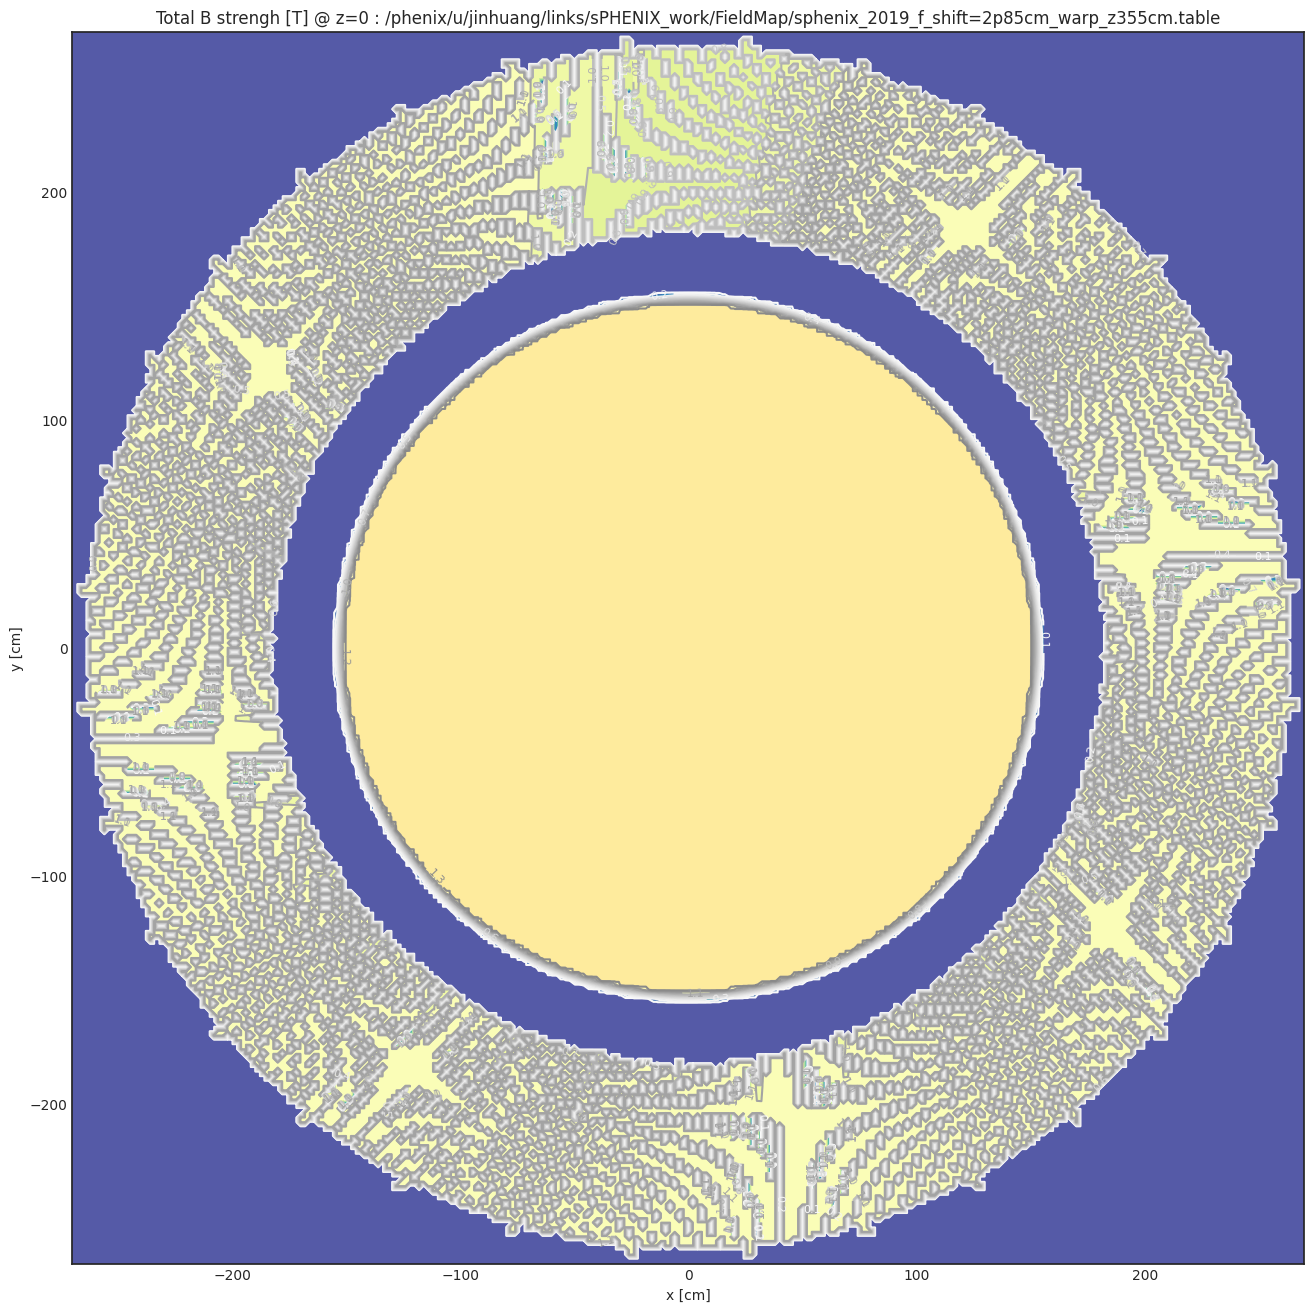

In [30]:
limits =  np.arange(0,2.5,.1);

fig, ax = plt.subplots(figsize=(16,16))
ax.set_aspect('equal')
ax.tricontourf(X,Y,Z,limits, cmap='Spectral_r') 
contours = ax.tricontour(X,Y,Z, limits)
ax.clabel(contours, inline=True, fontsize=8)

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title("Total B strengh [T] @ z=0 : " + MapFile3D)

fig.show()

## Check: folding data azimuthally to one sector

Next trick is for `z=0` plane, we can fold the HCal azimuthally 64 times to look at one sector. Then we have much better sampling of the space point

In [31]:



limits =  np.arange(0,2.5,.1);

/tmp/ipykernel_38734/3393381598.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


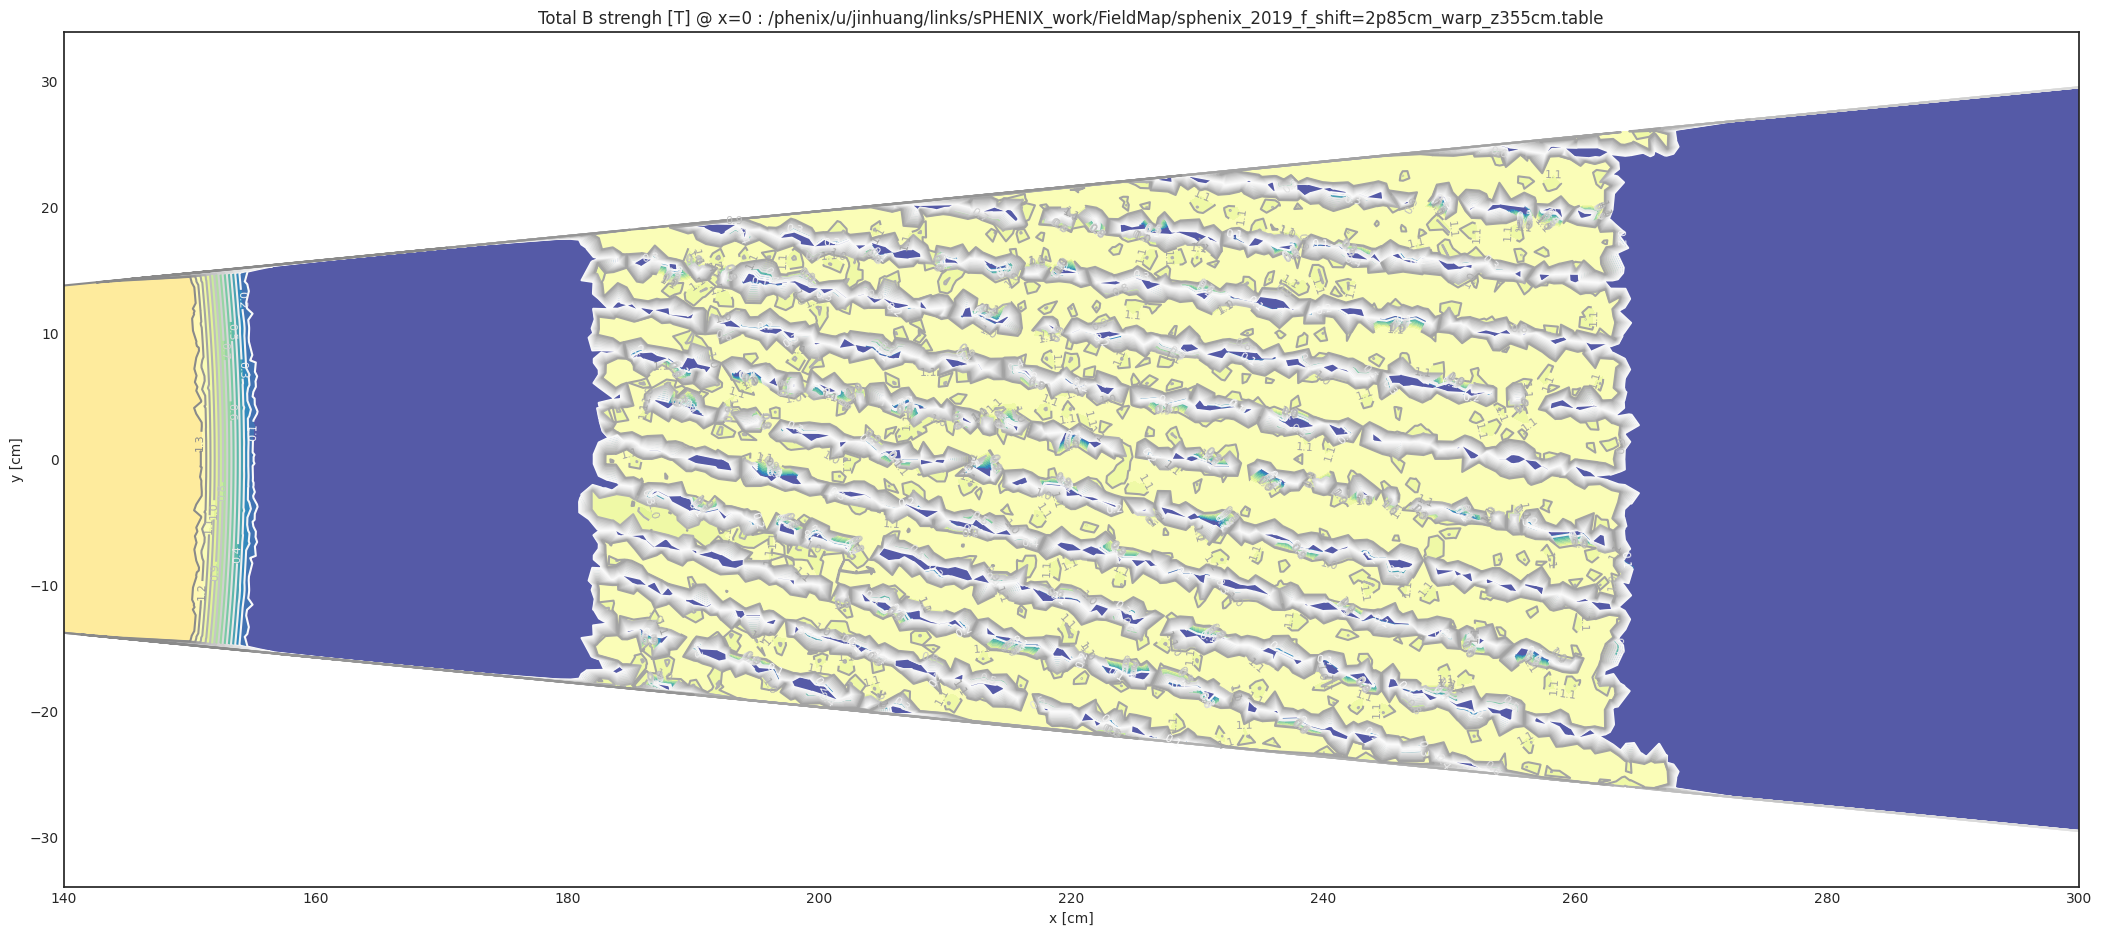

In [32]:
fig, ax = plt.subplots(figsize=(26,16))
ax.set_aspect('equal')
ax.tricontourf(df_fieldmap_xy['X_fold'].values,df_fieldmap_xy['Y_fold'].values,df_fieldmap_xy['B_tot'].values,limits, cmap='Spectral_r') 
contours = ax.tricontour(df_fieldmap_xy['X_fold'].values,df_fieldmap_xy['Y_fold'].values,df_fieldmap_xy['B_tot'].values, limits)
ax.clabel(contours, inline=True, fontsize=8)

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title("Total B strengh [T] @ x=0 : " + MapFile3D)
ax.set_xlim([140, 300])

fig.show()

In [33]:
df_fieldmap_xy

x        Y_fold      X_fold           R      phi_fmod     B_tot  \
178      -270.0  0.000000e+00  381.837662  381.837662  0.000000e+00  0.001255   
534      -270.0 -1.414214e+00  380.423448  380.426077 -3.717455e-03  0.001251   
890      -270.0 -2.828427e+00  379.009235  379.019788 -7.462548e-03  0.001247   
1246     -270.0 -4.242641e+00  377.595021  377.618855 -1.123548e-02  0.001242   
1602     -270.0 -5.656854e+00  376.180808  376.223338 -1.503646e-02  0.001238   
...         ...           ...         ...         ...           ...       ...   
26143394  270.0 -5.656854e+00  376.180808  376.223338 -1.503646e-02  0.001259   
26143750  270.0 -4.242641e+00  377.595021  377.618855 -1.123548e-02  0.001263   
26144106  270.0 -2.828427e+00  379.009235  379.019788 -7.462548e-03  0.001267   
26144462  270.0 -1.414214e+00  380.423448  380.426077 -3.717455e-03  0.001271   
26144818  270.0 -1.271775e-13  381.837662  381.837662 -3.330669e-16  0.001275   

              y    z  bx[Gauss]  by[Gauss]  bz[Gauss]  hz[OERSTED]        bx  \
178      -270.0  1.0   0.664671   0.484880 -12.523506   -12.523506  0.000066   
534      -268.0  1.0   0.671452   0.486166 -12.480930   -12.480930  0.000067   
890      -266.0  1.0   0.678281   0.487392 -12.438365   -12.438365  0.000068   
1246     -264.0  1.0   0.685158   0.488556 -12.395812   -12.395812  0.000069   
1602     -262.0  1.0   0.692085   0.489659 -12.353271   -12.353271  0.000069   
...         ...  ...        ...        ...        ...          ...       ...   
26143394  262.0  1.0  -0.221646  -1.343480 -12.517412   -12.517412 -0.000022   
26143750  264.0  1.0  -0.204574  -1.335475 -12.557507   -12.557507 -0.000020   
26144106  266.0  1.0  -0.187754  -1.327176 -12.597586   -12.597586 -0.000019   
26144462  268.0  1.0  -0.171185  -1.318587 -12.637650   -12.637650 -0.000017   
26144818  270.0  1.0  -0.154864  -1.309713 -12.677699   -12.677699 -0.000015   

                by        bz  
178       0.000048 -0.001252  
534       0.000049 -0.001248  
890       0.000049 -0.001244  
1246      0.000049 -0.001240  
1602      0.000049 -0.001235  
...            ...       ...  
26143394 -0.000134 -0.001252  
26143750 -0.000134 -0.001256  
26144106 -0.000133 -0.001260  
26144462 -0.000132 -0.001264  
26144818 -0.000131 -0.001268  

[73441 rows x 15 columns]

The separation of the field in gap (<0.1 T) and in steel (>0.1 T) is very clear 

  0%|          | 0/38059 [00:00<?, ?it/s]

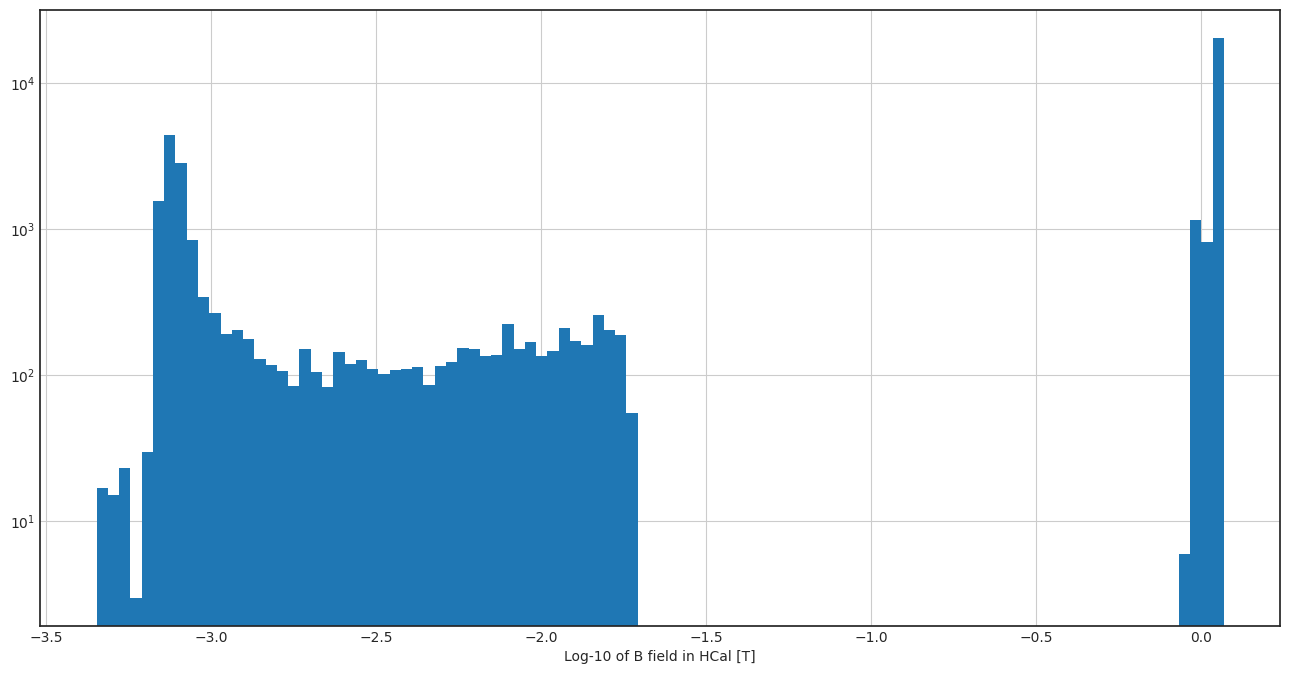

In [34]:
fig, ax = plt.subplots(figsize=(16,8))

hist = df_fieldmap_xy[(df_fieldmap_xy['X_fold'] >=170) & ( df_fieldmap_xy['X_fold'] <=280)].progress_apply(lambda x: np.log10(x['B_tot']), axis=1).hist(bins=100)
ax.set_xlabel('Log-10 of B field in HCal [T]');
ax.set_yscale('log')

Now perform the separation according the field value. We can get two maps, one for in-steel, one outside for one sector. 

In [35]:
df_fieldmap_xy_steel = df_fieldmap_xy[(df_fieldmap_xy['B_tot'] > 0.1)  & (df_fieldmap_xy['X_fold'] >=170) & ( df_fieldmap_xy['X_fold'] <=280)]
df_fieldmap_xy_gap = df_fieldmap_xy[(df_fieldmap_xy['B_tot'] < 0.1)  & (df_fieldmap_xy['X_fold'] >=170) & ( df_fieldmap_xy['X_fold'] <=280)]

/tmp/ipykernel_38734/3477960979.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


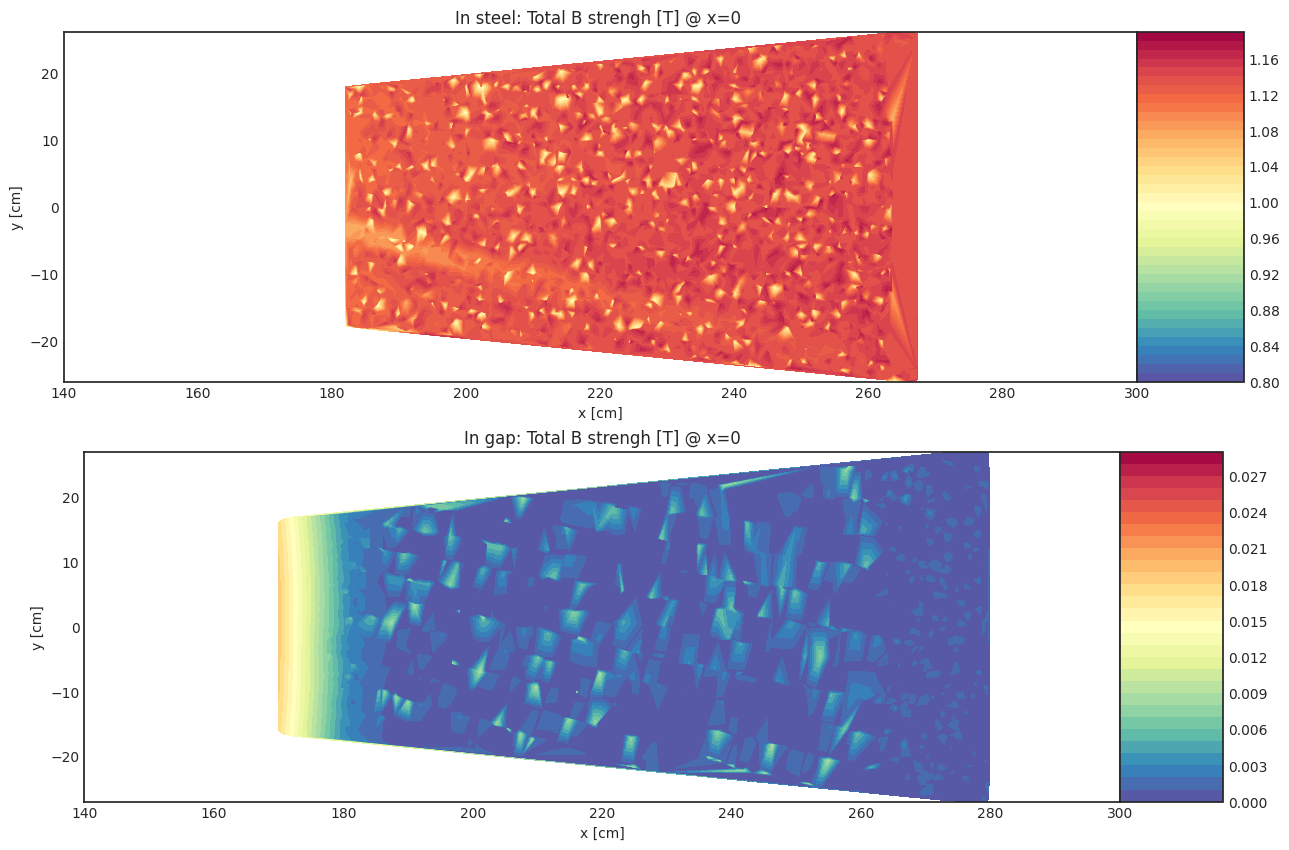

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(26,10))

ax = axs[0];

limits =  np.arange(.8,1.2,.01);
ax.set_aspect('equal')
tcf = ax.tricontourf(df_fieldmap_xy_steel['X_fold'].values,df_fieldmap_xy_steel['Y_fold'].values,df_fieldmap_xy_steel['B_tot'].values,limits, cmap='Spectral_r') 
# contours = ax.tricontour(df_fieldmap_xy_steel['X_fold'].values,df_fieldmap_xy_steel['Y_fold'].values,df_fieldmap_xy_steel['B_tot'].values, limits)
# ax.clabel(contours, inline=True, fontsize=8)
fig.colorbar(tcf, cax=make_axes_locatable(ax).append_axes('right', size='10%', pad=0.00), orientation='vertical')

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title("In steel: Total B strengh [T] @ x=0 " )
ax.set_xlim([140, 300])

ax = axs[1];

limits =  np.arange(0,.03,.001);
ax.set_aspect('equal')
tcf= ax.tricontourf(df_fieldmap_xy_gap['X_fold'].values,df_fieldmap_xy_gap['Y_fold'].values,df_fieldmap_xy_gap['B_tot'].values,limits, cmap='Spectral_r') 
# contours = ax.tricontour(df_fieldmap_xy_gap['X_fold'].values,df_fieldmap_xy_gap['Y_fold'].values,df_fieldmap_xy_gap['B_tot'].values, limits)
# ax.clabel(contours, inline=True, fontsize=8)
fig.colorbar(tcf, cax=make_axes_locatable(ax).append_axes('right', size='10%', pad=0.00), orientation='vertical')


ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title("In gap: Total B strengh [T] @ x=0")
ax.set_xlim([140, 300])

fig.show()

The field point sampled in the gap between steel fins are there, just relatively rare and random. Given from gap to gap, the field changes smoothly, we can use these information to interpolate and rebuild the field in and out of the steel separately in the next section. 

/tmp/ipykernel_38734/4042682801.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


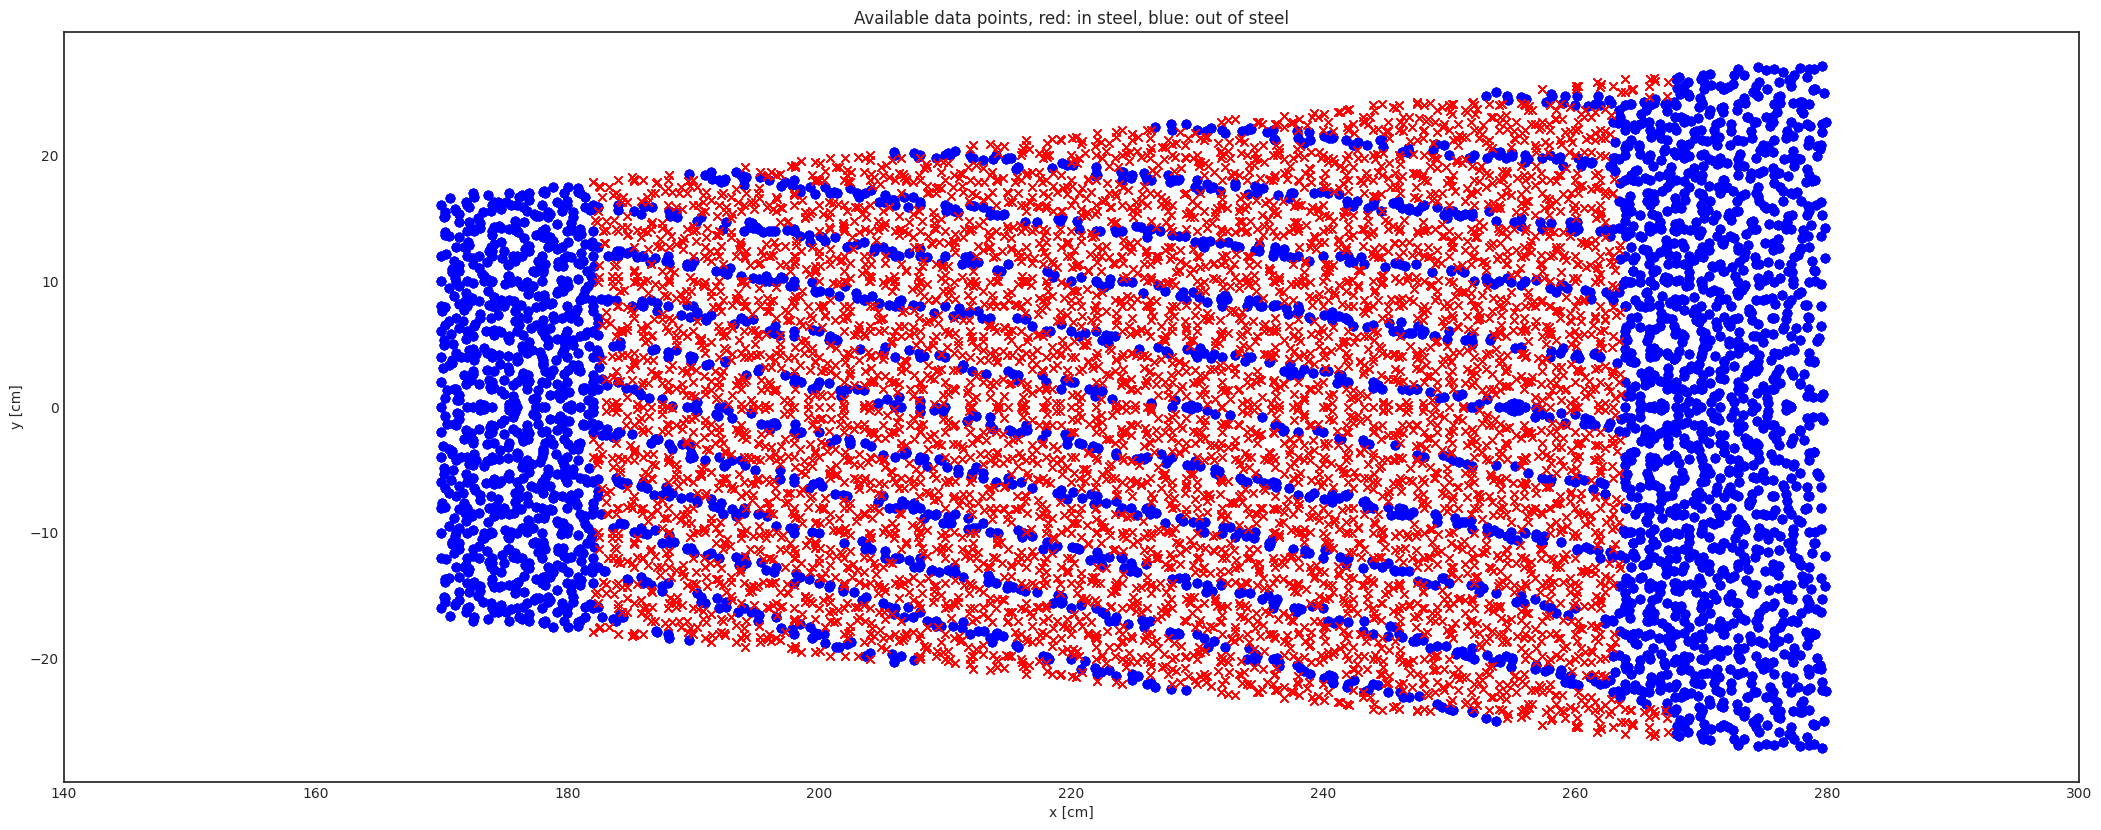

In [37]:
fig, ax = plt.subplots(figsize=(26,16))
ax.set_aspect('equal')
ax.plot(df_fieldmap_xy_gap['X_fold'], df_fieldmap_xy_gap['Y_fold'], 'o', color='blue')
ax.plot(df_fieldmap_xy_steel['X_fold'], df_fieldmap_xy_steel['Y_fold'], 'x', color='red')

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title("Available data points, red: in steel, blue: out of steel")
ax.set_xlim([140, 300])

fig.show()

## Steel vol.-separated 3D field

In [38]:
# df_fieldmap_central = df_fieldmap[(df_fieldmap['z'] > -10) & (df_fieldmap['z'] < 10)]
df_fieldmap_central = df_fieldmap

In [39]:
# df_fieldmap_central

In [40]:
# # Expensive ops

if not exists('df_fieldmap_steel.hdf5'):

    df_fieldmap_central['R'] = df_fieldmap_central.progress_apply(
        lambda x: np.sqrt(x['x']*x['x'] + x['y']*x['y'])
        , axis=1)

    df_fieldmap_central['In_Steel'] = df_fieldmap_central.progress_apply(
        lambda x: (df_fieldmap_xy[(df_fieldmap_xy['x'] == x['x']) & (df_fieldmap_xy['y'] == x['y'])]['B_tot'].mean() > 0.1) & (x['R'] >=170) & ( x['R'] <=280)
        , axis=1)

    df_fieldmap_steel = df_fieldmap_central[(df_fieldmap_central['In_Steel'])].copy(deep=True)
    df_fieldmap_gap =  df_fieldmap_central[~(df_fieldmap_central['In_Steel'])].copy(deep=True)

    df_fieldmap_steel.to_hdf('df_fieldmap_steel.hdf5', "df_fieldmap_steel");
    df_fieldmap_gap.to_hdf('df_fieldmap_gap.hdf5', "df_fieldmap_gap");


In [41]:
# Load preprocessed results
import uproot
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('seaborn-white')

import numpy as np

df_fieldmap_steel = pd.read_hdf('df_fieldmap_steel.hdf5', "df_fieldmap_steel");
df_fieldmap_gap= pd.read_hdf('df_fieldmap_gap.hdf5', "df_fieldmap_gap");
df_fieldmap_steel

/tmp/ipykernel_38734/1825635328.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


x     y      z    bx[Gauss]   by[Gauss]   bz[Gauss]  \
236028   -266.0 -28.0 -355.0    38.713399    4.612946  154.822260   
236029   -266.0 -28.0 -353.0    18.731954    2.245416  160.519947   
236030   -266.0 -28.0 -351.0  1225.121753  853.095150   29.493994   
236031   -266.0 -28.0 -349.0  1190.824984  892.897526   -4.032622   
236032   -266.0 -28.0 -347.0  1169.003748  910.886228  -81.536536   
...         ...   ...    ...          ...         ...         ...   
25908963  266.0  28.0  347.0  1486.476549 -240.519614  -68.071314   
25908964  266.0  28.0  349.0  1490.451940 -242.668033   10.831833   
25908965  266.0  28.0  351.0  1487.086662 -264.415956   45.540465   
25908966  266.0  28.0  353.0    18.324241    1.857388  171.230030   
25908967  266.0  28.0  355.0    37.860509    3.855034  165.098453   

          hz[OERSTED]        bx        by        bz           R  In_Steel  
236028     154.822260  0.003871  0.000461  0.015482  267.469624      True  
236029     160.519947  0.001873  0.000225  0.016052  267.469624      True  
236030       0.001344  0.122512  0.085310  0.002949  267.469624      True  
236031      -0.000078  0.119082  0.089290 -0.000403  267.469624      True  
236032      -0.003186  0.116900  0.091089 -0.008154  267.469624      True  
...               ...       ...       ...       ...         ...       ...  
25908963    -0.002676  0.148648 -0.024052 -0.006807  267.469624      True  
25908964     0.000524  0.149045 -0.024267  0.001083  267.469624      True  
25908965     0.002017  0.148709 -0.026442  0.004554  267.469624      True  
25908966   171.230030  0.001832  0.000186  0.017123  267.469624      True  
25908967   165.098453  0.003786  0.000386  0.016510  267.469624      True  

[7984368 rows x 12 columns]

Back to unfolded space, here is the available points in-steel vs out of steel, which is sparsely distributed in the outer HCal

/tmp/ipykernel_38734/2291447805.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


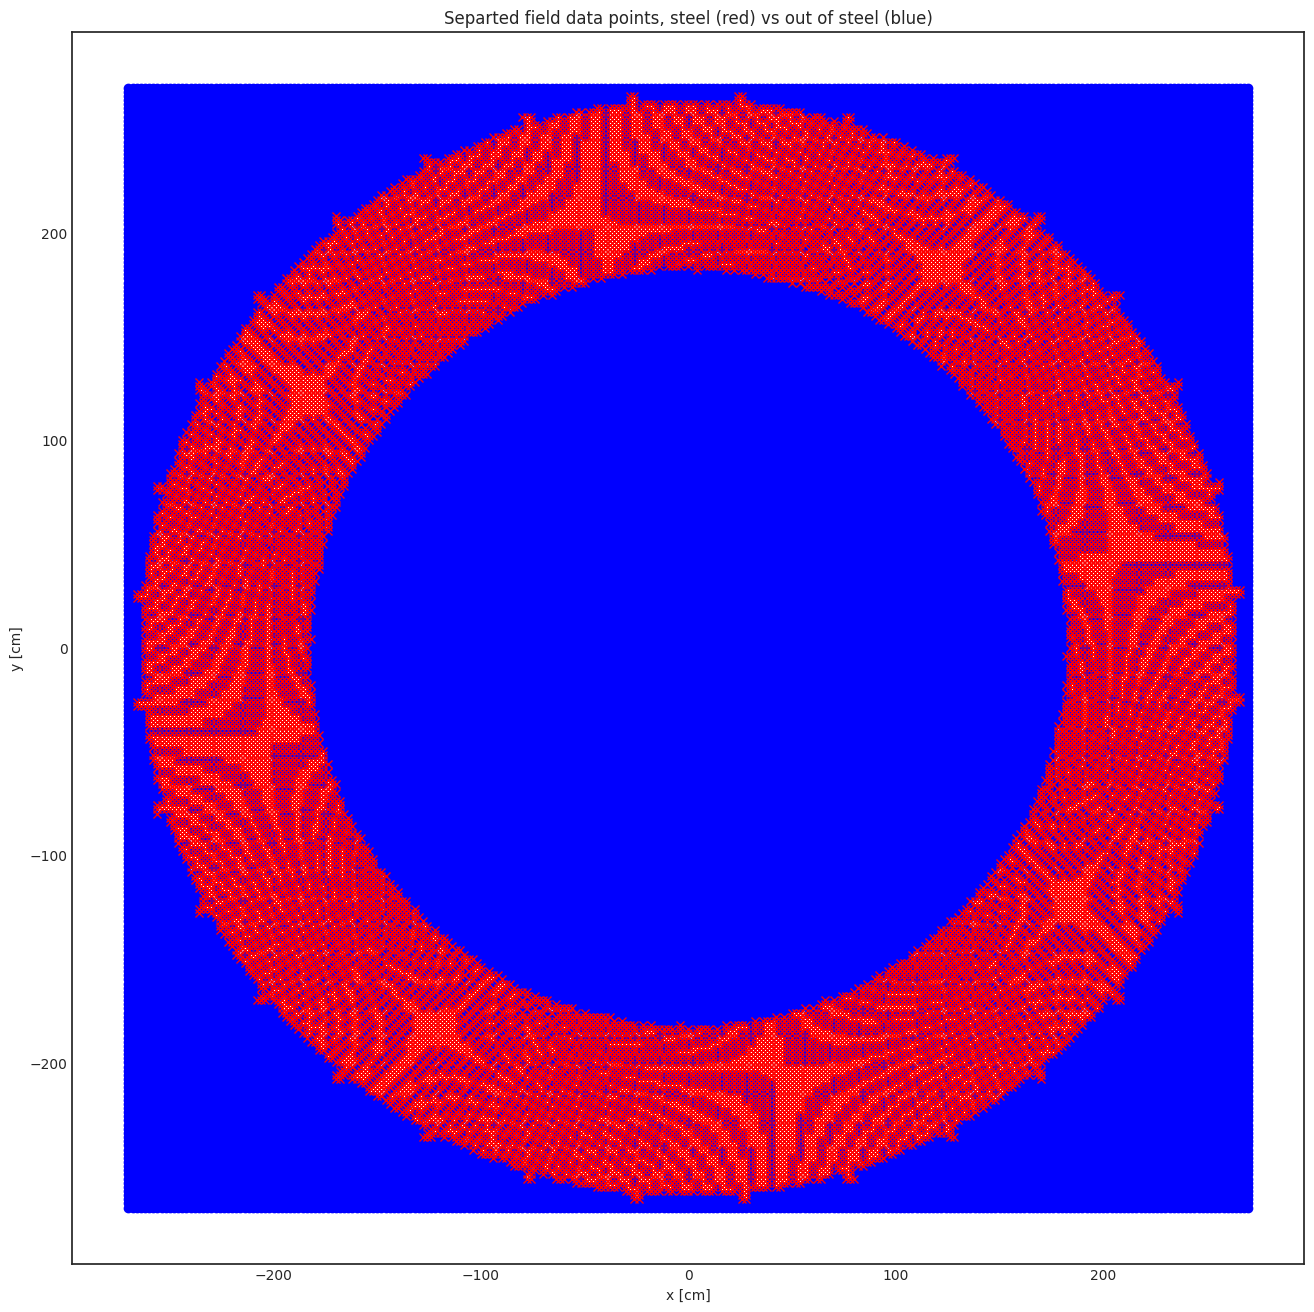

In [42]:
df_fieldmap_xy_gap = df_fieldmap_gap[(df_fieldmap_gap['z'] >= 0) & (df_fieldmap_gap['z'] <=1)]
df_fieldmap_xy_steel = df_fieldmap_steel[(df_fieldmap_steel['z'] >= 0) & (df_fieldmap_steel['z'] <= 1)]

fig, ax = plt.subplots(figsize=(26,16))
ax.set_aspect('equal')
ax.plot(df_fieldmap_xy_gap['x'], df_fieldmap_xy_gap['y'], 'o', color='blue')
ax.plot(df_fieldmap_xy_steel['x'], df_fieldmap_xy_steel['y'], 'x', color='red')

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title("Separted field data points, steel (red) vs out of steel (blue)")

fig.show()

Steel separated 3D field at z=0 plane: 

  0%|          | 0/22428 [00:00<?, ?it/s]

  0%|          | 0/51013 [00:00<?, ?it/s]

/tmp/ipykernel_38734/1779233984.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


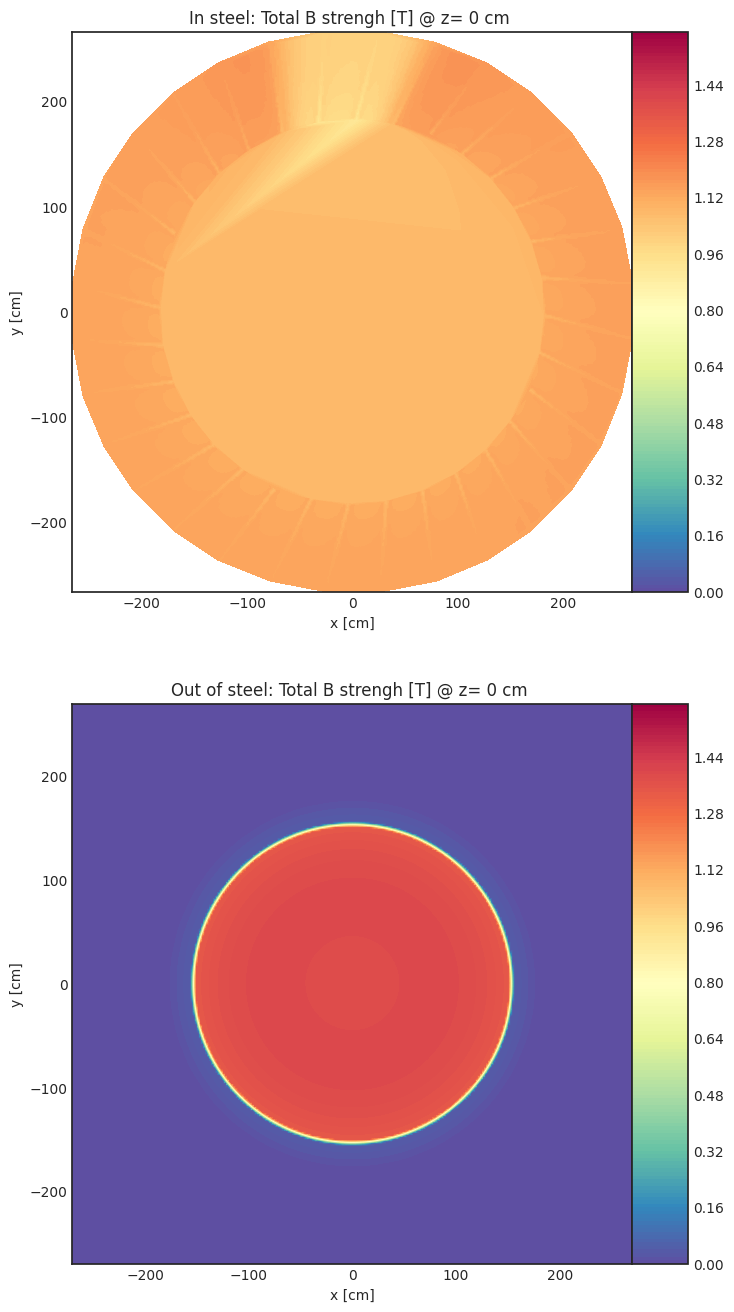

In [44]:
df_fieldmap_xy_gap = df_fieldmap_gap[(df_fieldmap_gap['z'] >= 0) & (df_fieldmap_gap['z'] <= 1)]
df_fieldmap_xy_steel = df_fieldmap_steel[(df_fieldmap_steel['z'] >=0) & (df_fieldmap_steel['z'] <= 1)]


limits =  np.arange(0,1.6,.01);

fig, axs = plt.subplots(2,1, figsize=(32,16))

ax = axs[0]
ax.set_aspect('equal')
tcf = ax.tricontourf(df_fieldmap_xy_steel['x'].values, df_fieldmap_xy_steel['y'].values, df_fieldmap_xy_steel.progress_apply(lambda x: np.sqrt(x['bx']*x['bx'] + x['by']*x['by'] + x['bz']*x['bz']), axis=1).values,
               limits, cmap='Spectral_r') 
# contours = ax.tricontour(X,Y,Z, limits)
# ax.clabel(contours, inline=True, fontsize=8)
fig.colorbar(tcf, cax=make_axes_locatable(ax).append_axes('right', size='10%', pad=0.00), orientation='vertical')

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title("In steel: Total B strengh [T] @ z= 0 cm ")


ax = axs[1]
ax.set_aspect('equal')
tcf = ax.tricontourf(df_fieldmap_xy_gap['x'].values, df_fieldmap_xy_gap['y'].values, df_fieldmap_xy_gap.progress_apply(lambda x: np.sqrt(x['bx']*x['bx'] + x['by']*x['by'] + x['bz']*x['bz']), axis=1).values,
               limits, cmap='Spectral_r') 
# contours = ax.tricontour(X,Y,Z, limits)
# ax.clabel(contours, inline=True, fontsize=8)
fig.colorbar(tcf, cax=make_axes_locatable(ax).append_axes('right', size='10%', pad=0.00), orientation='vertical')


ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title("Out of steel: Total B strengh [T] @ z= 0 cm ")

fig.show()

Steel separated 3D field at z=-250 plane, that include the HCal cut off for the magnet chimney. A field irregularity is obvious around the cut off structure. 

  0%|          | 0/22428 [00:00<?, ?it/s]

  0%|          | 0/51013 [00:00<?, ?it/s]

/tmp/ipykernel_38734/4128578833.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


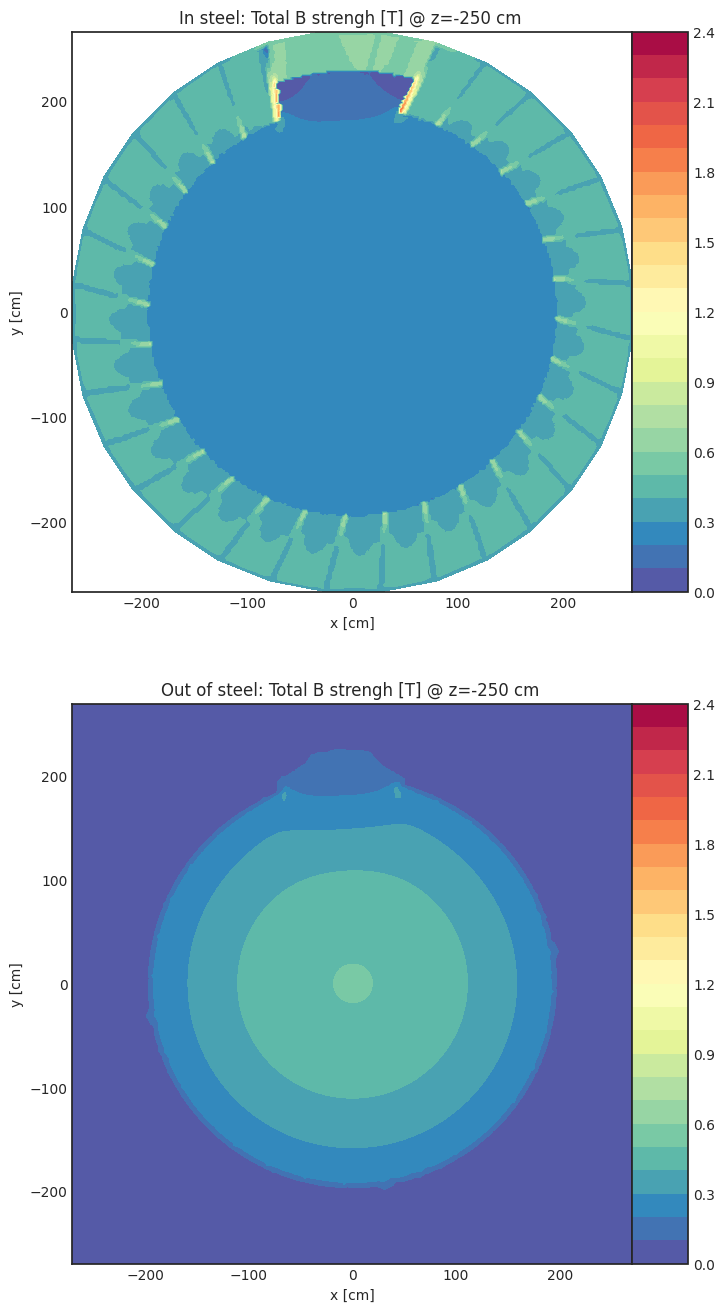

In [46]:
df_fieldmap_xy_gap = df_fieldmap_gap[df_fieldmap_gap['z'] == -251]
df_fieldmap_xy_steel = df_fieldmap_steel[df_fieldmap_steel['z'] == -251]


limits =  np.arange(0,2.5,.1);

fig, axs = plt.subplots(2,1, figsize=(32,16))

ax = axs[0]
ax.set_aspect('equal')
tcf = ax.tricontourf(df_fieldmap_xy_steel['x'].values, df_fieldmap_xy_steel['y'].values, df_fieldmap_xy_steel.progress_apply(lambda x: np.sqrt(x['bx']*x['bx'] + x['by']*x['by'] + x['bz']*x['bz']), axis=1).values,
               limits, cmap='Spectral_r') 
# contours = ax.tricontour(X,Y,Z, limits)
# ax.clabel(contours, inline=True, fontsize=8)
fig.colorbar(tcf, cax=make_axes_locatable(ax).append_axes('right', size='10%', pad=0.00), orientation='vertical')

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title("In steel: Total B strengh [T] @ z=-250 cm ")


ax = axs[1]
ax.set_aspect('equal')
tcf = ax.tricontourf(df_fieldmap_xy_gap['x'].values, df_fieldmap_xy_gap['y'].values, df_fieldmap_xy_gap.progress_apply(lambda x: np.sqrt(x['bx']*x['bx'] + x['by']*x['by'] + x['bz']*x['bz']), axis=1).values,
               limits, cmap='Spectral_r') 
# contours = ax.tricontour(X,Y,Z, limits)
# ax.clabel(contours, inline=True, fontsize=8)
fig.colorbar(tcf, cax=make_axes_locatable(ax).append_axes('right', size='10%', pad=0.00), orientation='vertical')


ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title("Out of steel: Total B strengh [T] @ z=-250 cm ")

fig.show()

/tmp/ipykernel_38734/2116392683.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


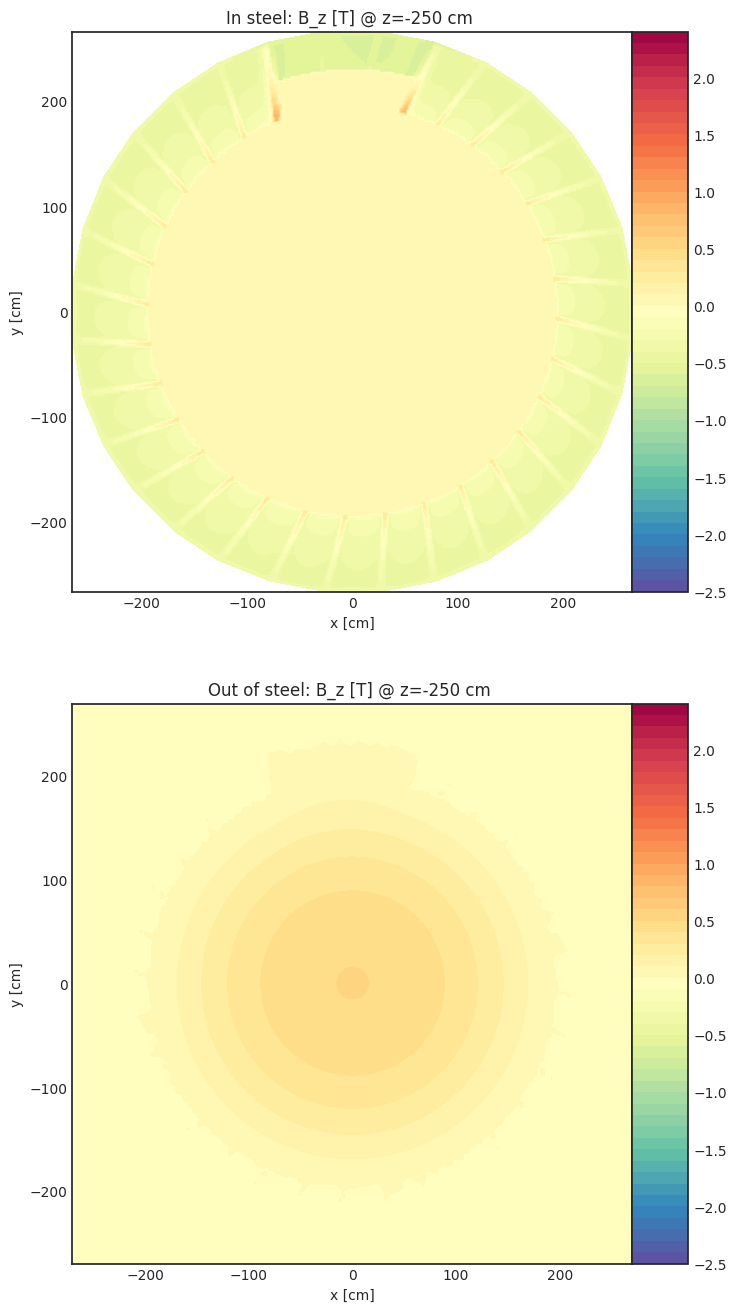

In [47]:
df_fieldmap_xy_gap = df_fieldmap_gap[df_fieldmap_gap['z'] == -251]
df_fieldmap_xy_steel = df_fieldmap_steel[df_fieldmap_steel['z'] == -251]


limits =  np.arange(-2.5,2.5,.1);

fig, axs = plt.subplots(2,1, figsize=(32,16))

ax = axs[0]
ax.set_aspect('equal')
tcf = ax.tricontourf(df_fieldmap_xy_steel['x'].values, df_fieldmap_xy_steel['y'].values,  df_fieldmap_xy_steel['bz'].values,
               limits, cmap='Spectral_r') 
# contours = ax.tricontour(X,Y,Z, limits)
# ax.clabel(contours, inline=True, fontsize=8)
fig.colorbar(tcf, cax=make_axes_locatable(ax).append_axes('right', size='10%', pad=0.00), orientation='vertical')

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title("In steel: B_z [T] @ z=-250 cm ")


ax = axs[1]
ax.set_aspect('equal')
tcf = ax.tricontourf(df_fieldmap_xy_gap['x'].values, df_fieldmap_xy_gap['y'].values,  df_fieldmap_xy_gap['bz'].values,
               limits, cmap='Spectral_r') 
# contours = ax.tricontour(X,Y,Z, limits)
# ax.clabel(contours, inline=True, fontsize=8)
fig.colorbar(tcf, cax=make_axes_locatable(ax).append_axes('right', size='10%', pad=0.00), orientation='vertical')


ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title("Out of steel: B_z [T] @ z=-250 cm ")

fig.show()

Next, let's check the field in the endcap

/tmp/ipykernel_38734/1017372771.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


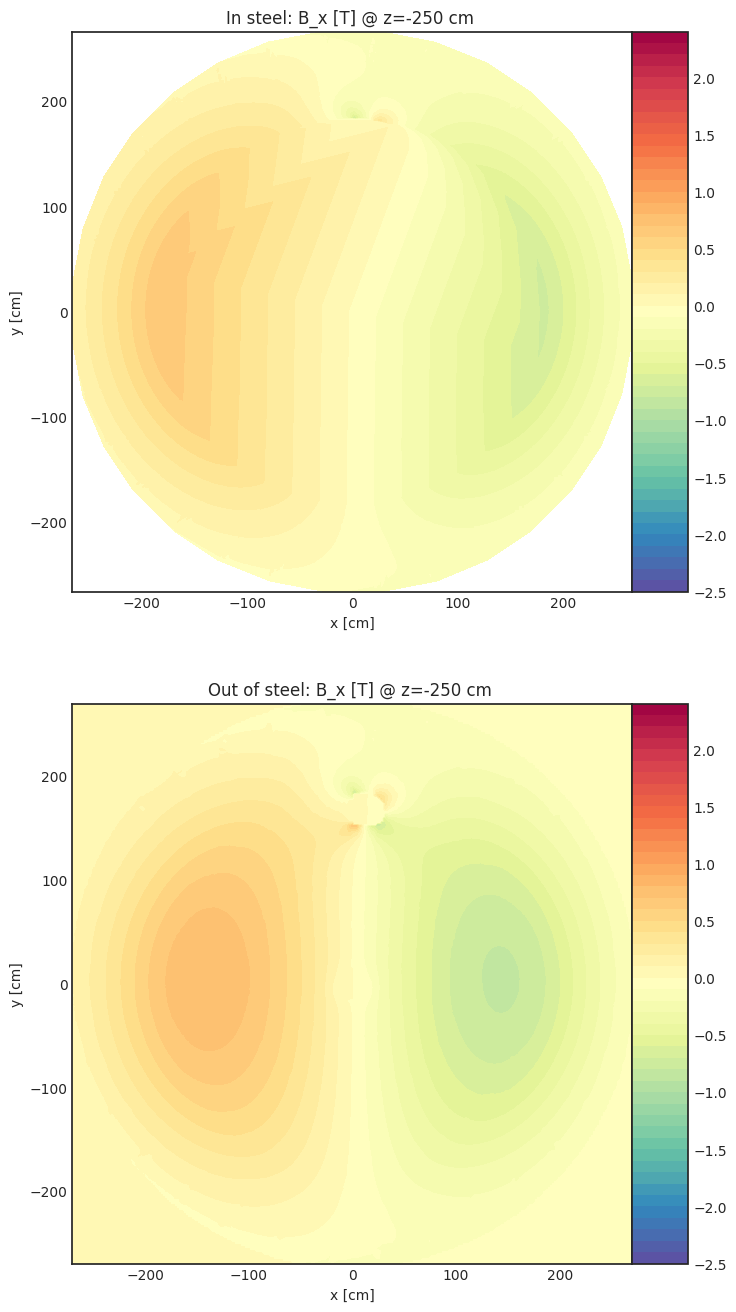

In [49]:
df_fieldmap_xy_gap = df_fieldmap_gap[df_fieldmap_gap['z'] == -341]
df_fieldmap_xy_steel = df_fieldmap_steel[df_fieldmap_steel['z'] == -341]


limits =  np.arange(-2.5,2.5,.1);

fig, axs = plt.subplots(2,1, figsize=(32,16))

ax = axs[0]
ax.set_aspect('equal')
tcf = ax.tricontourf(df_fieldmap_xy_steel['x'].values, df_fieldmap_xy_steel['y'].values,  df_fieldmap_xy_steel['bx'].values,
               limits, cmap='Spectral_r') 
# contours = ax.tricontour(X,Y,Z, limits)
# ax.clabel(contours, inline=True, fontsize=8)
fig.colorbar(tcf, cax=make_axes_locatable(ax).append_axes('right', size='10%', pad=0.00), orientation='vertical')

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title("In steel: B_x [T] @ z=-250 cm ")


ax = axs[1]
ax.set_aspect('equal')
tcf = ax.tricontourf(df_fieldmap_xy_gap['x'].values, df_fieldmap_xy_gap['y'].values,  df_fieldmap_xy_gap['bx'].values,
               limits, cmap='Spectral_r') 
# contours = ax.tricontour(X,Y,Z, limits)
# ax.clabel(contours, inline=True, fontsize=8)
fig.colorbar(tcf, cax=make_axes_locatable(ax).append_axes('right', size='10%', pad=0.00), orientation='vertical')


ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title("Out of steel: B_x [T] @ z=-250 cm ")

fig.show()

# Rebuild map with in/out steel separation

Now the rebuilding part to make two 3D field map, one for gap and one for steel vols in Geant4. It is OK if the simulation has a small geometry offset from the field calculation, as the field for each of these two types of volumns are mostly continous function through the 3D space. Then we can rely on Geant4 vol tracking to determine the volumn boundary. 

We use a 3D linear interpolation to map out the field in gap and steel separately with `scipy.interpolate.griddata`. One trick to speed up calculation is to interpolate at the same z-grid as the original field map (2cm grid), then the interpolation become 2D problem at each z-plane independently. 

In [50]:
df_fieldmap_steel_rebuild = pd.DataFrame({"x":[] , "y":[] , "z":[] , "bx":[] , "by":[] , "bz":[] , })
df_fieldmap_gap_rebuild = df_fieldmap_steel_rebuild.copy()


In [51]:
# expensive operation

from scipy.interpolate import griddata as griddata

if not exists('df_fieldmap_steel_rebuild.hdf5'):
    
    zs = df_fieldmap.z.unique()

    for z in zs:
    # for z in [0]: 
        print(f"processing z = {z}")

        df_fieldmap_zselect =  df_fieldmap[df_fieldmap['z'] == z]
        df_fieldmap_steel_zselect =  df_fieldmap_steel[df_fieldmap_steel['z'] == z]
        df_fieldmap_gap_zselect =  df_fieldmap_gap[df_fieldmap_gap['z'] == z]

        df_fieldmap_steel_rebuild_zselect = pd.DataFrame({"x":df_fieldmap_zselect.x 
                          , "y":df_fieldmap_zselect.y 
                          , "z":df_fieldmap_zselect.z 
                          , "bx":np.nan_to_num(griddata((df_fieldmap_steel_zselect.x,df_fieldmap_steel_zselect.y)
                              , df_fieldmap_steel_zselect.bx, 
                              (df_fieldmap_zselect.x.array, df_fieldmap_zselect.y.array)
                              , method='linear')) 
                          , "by":np.nan_to_num(griddata((df_fieldmap_steel_zselect.x,df_fieldmap_steel_zselect.y)
                              , df_fieldmap_steel_zselect.by, 
                              (df_fieldmap_zselect.x.array, df_fieldmap_zselect.y.array)
                              , method='linear')) 
                          , "bz":np.nan_to_num(griddata((df_fieldmap_steel_zselect.x,df_fieldmap_steel_zselect.y)
                              , df_fieldmap_steel_zselect.bz, 
                              (df_fieldmap_zselect.x.array, df_fieldmap_zselect.y.array)
                              , method='linear'))
                          , })
        df_fieldmap_steel_rebuild = pd.concat([df_fieldmap_steel_rebuild , df_fieldmap_steel_rebuild_zselect])
        # df_fieldmap_steel_rebuild.append(df_fieldmap_steel_rebuild_zselect)


        df_fieldmap_gap_rebuild_zselect = pd.DataFrame({"x":df_fieldmap_zselect.x 
                          , "y":df_fieldmap_zselect.y 
                          , "z":df_fieldmap_zselect.z 
                          , "bx":np.nan_to_num(griddata((df_fieldmap_gap_zselect.x,df_fieldmap_gap_zselect.y)
                              , df_fieldmap_gap_zselect.bx, 
                              (df_fieldmap_zselect.x.array, df_fieldmap_zselect.y.array)
                              , method='linear')) 
                          , "by":np.nan_to_num(griddata((df_fieldmap_gap_zselect.x,df_fieldmap_gap_zselect.y)
                              , df_fieldmap_gap_zselect.by, 
                              (df_fieldmap_zselect.x.array, df_fieldmap_zselect.y.array)
                              , method='linear')) 
                          , "bz":np.nan_to_num(griddata((df_fieldmap_gap_zselect.x,df_fieldmap_gap_zselect.y)
                              , df_fieldmap_gap_zselect.bz, 
                              (df_fieldmap_zselect.x.array, df_fieldmap_zselect.y.array)
                              , method='linear'))
                          , })
        # df_fieldmap_gap_rebuild = df_fieldmap_gap_rebuild.append(df_fieldmap_gap_rebuild_zselect)
        df_fieldmap_gap_rebuild = pd.concat([df_fieldmap_gap_rebuild , df_fieldmap_gap_rebuild_zselect])


    df_fieldmap_steel_rebuild.to_hdf('df_fieldmap_steel_rebuild.hdf5', "df_fieldmap_steel_rebuild");
    df_fieldmap_gap_rebuild.to_hdf('df_fieldmap_gap_rebuild.hdf5', "df_fieldmap_gap_rebuild");

processing z = -355.0
processing z = -353.0
processing z = -351.0
processing z = -349.0
processing z = -347.0
processing z = -345.0
processing z = -343.0
processing z = -341.0
processing z = -339.0
processing z = -337.0
processing z = -335.0
processing z = -333.0
processing z = -331.0
processing z = -329.0
processing z = -327.0
processing z = -325.0
processing z = -323.0
processing z = -321.0
processing z = -319.0
processing z = -317.0
processing z = -315.0
processing z = -313.0
processing z = -311.0
processing z = -309.0
processing z = -307.0
processing z = -305.0
processing z = -303.0
processing z = -301.0
processing z = -299.0
processing z = -297.0
processing z = -295.0
processing z = -293.0
processing z = -291.0
processing z = -289.0
processing z = -287.0
processing z = -285.0
processing z = -283.0
processing z = -281.0
processing z = -279.0
processing z = -277.0
processing z = -275.0
processing z = -273.0
processing z = -271.0
processing z = -269.0
processing z = -267.0
processing

In [52]:
df_fieldmap_steel_rebuild = pd.read_hdf('df_fieldmap_steel_rebuild.hdf5', "df_fieldmap_steel_rebuild");
df_fieldmap_gap_rebuild = pd.read_hdf('df_fieldmap_gap_rebuild.hdf5', "df_fieldmap_gap_rebuild");

Here is quick check plot for a given $z$ plane for the set of two field map

/tmp/ipykernel_38734/4229296759.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


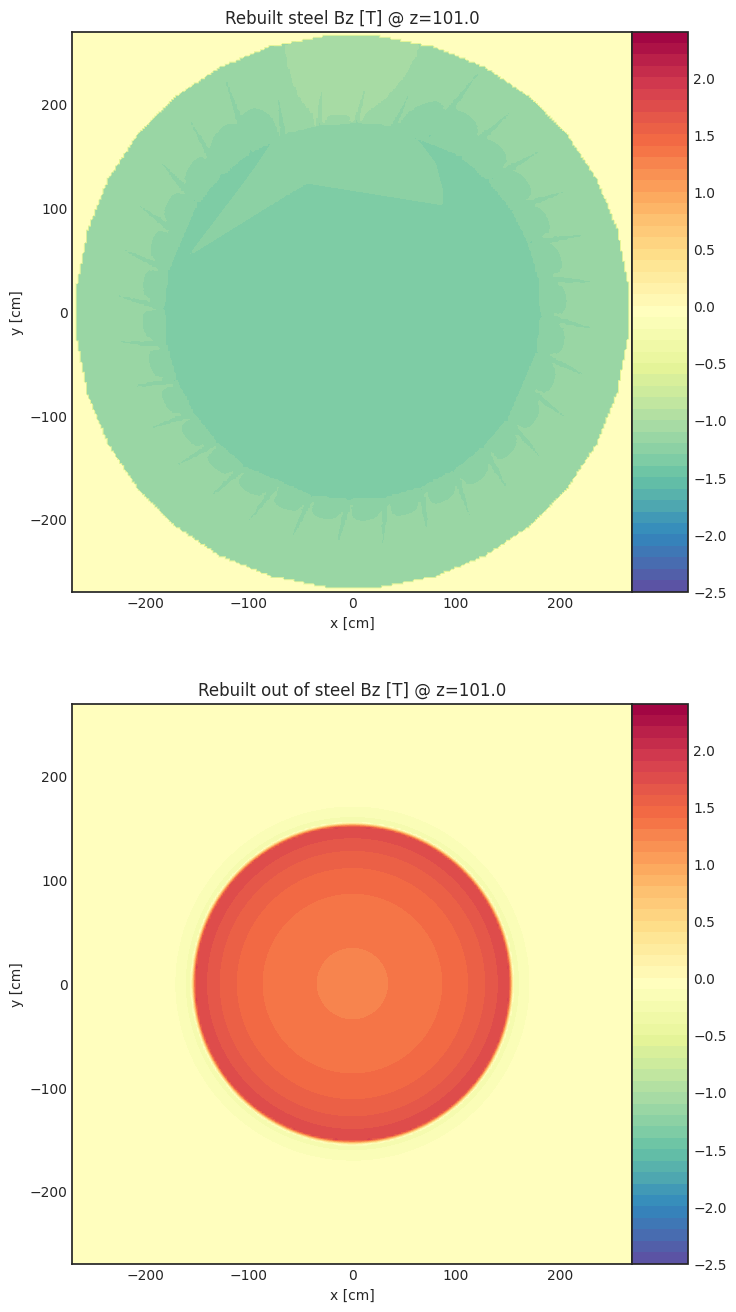

In [54]:
limits =  np.arange(0-2.5,2.5,.1);

df_fieldmap_steel_zselect = df_fieldmap_steel_rebuild[df_fieldmap_steel_rebuild['z'] == 101]
df_fieldmap_gap_rebuild_zselect = df_fieldmap_gap_rebuild[df_fieldmap_gap_rebuild['z'] == 101]

fig, axs = plt.subplots(2,1,figsize=(32,16))

ax = axs[0]
ax.set_aspect('equal')
tcf = ax.tricontourf(
    df_fieldmap_steel_zselect['x'].values
    ,df_fieldmap_steel_zselect['y'].values
    ,df_fieldmap_steel_zselect['bz'].values
    ,limits, cmap='Spectral_r') 
fig.colorbar(tcf, cax=make_axes_locatable(ax).append_axes('right', size='10%', pad=0.00), orientation='vertical')


ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title(f"Rebuilt steel Bz [T] @ z={df_fieldmap_steel_zselect.z.iloc[0]}")

ax = axs[1]
ax.set_aspect('equal')
tcf = ax.tricontourf(
    df_fieldmap_gap_rebuild_zselect['x'].values
    ,df_fieldmap_gap_rebuild_zselect['y'].values
    ,df_fieldmap_gap_rebuild_zselect['bz'].values
    ,limits, cmap='Spectral_r') 
fig.colorbar(tcf, cax=make_axes_locatable(ax).append_axes('right', size='10%', pad=0.00), orientation='vertical')


ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_title(f"Rebuilt out of steel Bz [T] @ z={df_fieldmap_gap_rebuild_zselect.z.iloc[0]}")

fig.show()

Output to field map in the ROOT file format

In [55]:

if not exists('sphenix3dbigmapxyz_gap_rebuild.root'):
    TFile_fieldmap_gap_rebuild = ROOT.TFile.Open("sphenix3dbigmapxyz_gap_rebuild.root","recreate")
    TNtuple_fieldmap_gap_rebuild = ROOT.TNtuple("fieldmap"
                                              , "Rebuilt field map out side the HCal steel vol."
                                             , "x:y:z:bx:by:bz")

    counter = 0
    for index, row in df_fieldmap_gap_rebuild.iterrows():
        if counter % 100000 == 0:
            print(f"Processing {counter}")
        counter = counter + 1

        TNtuple_fieldmap_gap_rebuild.Fill(row.x, row.y, row.z, row.bx, row.by, row.bz)

    TFile_fieldmap_gap_rebuild.Write()

Processing 0
Processing 100000
Processing 200000
Processing 300000
Processing 400000
Processing 500000
Processing 600000
Processing 700000
Processing 800000
Processing 900000
Processing 1000000
Processing 1100000
Processing 1200000
Processing 1300000
Processing 1400000
Processing 1500000
Processing 1600000
Processing 1700000
Processing 1800000
Processing 1900000
Processing 2000000
Processing 2100000
Processing 2200000
Processing 2300000
Processing 2400000
Processing 2500000
Processing 2600000
Processing 2700000
Processing 2800000
Processing 2900000
Processing 3000000
Processing 3100000
Processing 3200000
Processing 3300000
Processing 3400000
Processing 3500000
Processing 3600000
Processing 3700000
Processing 3800000
Processing 3900000
Processing 4000000
Processing 4100000
Processing 4200000
Processing 4300000
Processing 4400000
Processing 4500000
Processing 4600000
Processing 4700000
Processing 4800000
Processing 4900000
Processing 5000000
Processing 5100000
Processing 5200000
Processi

In [56]:
TFile_fieldmap_gap_rebuild = ROOT.TFile.Open("sphenix3dbigmapxyz_gap_rebuild.root")

display(Markdown(f"`{TFile_fieldmap_gap_rebuild.GetName()}` contains {TFile_fieldmap_gap_rebuild.fieldmap.GetEntries()} records. First record:"))
TFile_fieldmap_gap_rebuild.fieldmap.Show(0)

`sphenix3dbigmapxyz_gap_rebuild.root` contains 26144996 records. First record:

======> EVENT:0
 x               = -270
 y               = -270
 z               = -355
 bx              = 0.00180743
 by              = 0.00179699
 bz              = -0.00213512


In [57]:

if not exists('sphenix3dbigmapxyz_steel_rebuild.root'):

    TFile_fieldmap_steel_rebuild = ROOT.TFile.Open("sphenix3dbigmapxyz_steel_rebuild.root","recreate")
    TNtuple_fieldmap_steel_rebuild = ROOT.TNtuple("fieldmap"
                                              , "Rebuilt field map out side the HCal steel vol."
                                             , "x:y:z:bx:by:bz")

    counter = 0
    for index, row in df_fieldmap_steel_rebuild.iterrows():
        if counter % 100000 == 0:
            print(f"Processing {counter}")
        counter = counter + 1

        TNtuple_fieldmap_steel_rebuild.Fill(row.x, row.y, row.z, row.bx, row.by, row.bz)

    TFile_fieldmap_steel_rebuild.Write()

Processing 0
Processing 100000
Processing 200000
Processing 300000
Processing 400000
Processing 500000
Processing 600000
Processing 700000
Processing 800000
Processing 900000
Processing 1000000
Processing 1100000
Processing 1200000
Processing 1300000
Processing 1400000
Processing 1500000
Processing 1600000
Processing 1700000
Processing 1800000
Processing 1900000
Processing 2000000
Processing 2100000
Processing 2200000
Processing 2300000
Processing 2400000
Processing 2500000
Processing 2600000
Processing 2700000
Processing 2800000
Processing 2900000
Processing 3000000
Processing 3100000
Processing 3200000
Processing 3300000
Processing 3400000
Processing 3500000
Processing 3600000
Processing 3700000
Processing 3800000
Processing 3900000
Processing 4000000
Processing 4100000
Processing 4200000
Processing 4300000
Processing 4400000
Processing 4500000
Processing 4600000
Processing 4700000
Processing 4800000
Processing 4900000
Processing 5000000
Processing 5100000
Processing 5200000
Processi

In [58]:
TFile_fieldmap_steel_rebuild = ROOT.TFile.Open("sphenix3dbigmapxyz_steel_rebuild.root")

display(Markdown(f"`{TFile_fieldmap_steel_rebuild.GetName()}` contains {TFile_fieldmap_steel_rebuild.fieldmap.GetEntries()} records. 10000000th record:"))
TFile_fieldmap_steel_rebuild.fieldmap.Show(10000000)

`sphenix3dbigmapxyz_steel_rebuild.root` contains 26144996 records. 10000000th record:

======> EVENT:10000000
 x               = -182
 y               = -70
 z               = -83
 bx              = -0.0142514
 by              = -0.00272732
 bz              = -1.23046
